In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import ast

In [24]:
def get_page_size(url):
    response = requests.get(url)
    page_size = len(response.content) / 1024  # Convert bytes to kilobytes
    return page_size

In [25]:
def get_resource_size(base_url, resource_url):
    if resource_url.startswith('http'):
        absolute_url = resource_url
    else:
        absolute_url = f'{base_url}/{resource_url}'  # Handle relative URLs
    
    response = requests.head(absolute_url)
    resource_size = int(response.headers.get('content-length', 0)) / 1024  # Convert bytes to kilobytes
    return resource_size

In [26]:
def analyze_resources(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    resource_sizes = []
    
    # Analyze images
    images = soup.find_all('img')
    for img in images:
        img_url = img.get('src')
        img_size = get_resource_size(url, img_url)
        resource_sizes.append((img_url, img_size))
    
    # Analyze scripts
    scripts = soup.find_all('script')
    for script in scripts:
        script_url = script.get('src')
        if script_url:
            script_size = get_resource_size(url, script_url)
            resource_sizes.append((script_url, script_size))
    
    # Analyze stylesheets
    stylesheets = soup.find_all('link', rel='stylesheet')
    for stylesheet in stylesheets:
        stylesheet_url = stylesheet.get('href')
        if stylesheet_url:
            stylesheet_size = get_resource_size(url, stylesheet_url)
            resource_sizes.append((stylesheet_url, stylesheet_size))
    
    return resource_sizes

In [32]:
# Read the CSV file into a DataFrame
input_csv = '../EveryTraceOfFampayPeriod/famapp_unique_links.csv'
output_csv = 'resources.csv'

# read and save input csv to a df
df = pd.read_csv(input_csv)


# Create new columns for page size and resource sizes
df['Page Size (KB)'] = None
df['Resource Sizes'] = None

Analyzing 1 of 523: https://famapp.in/
Page size: 32.552734375 KB
Resource sizes: [('/assets/images/icons/common/partyCapIcon.svg', 0.0), ('/assets/images/icons/common/partyFaceIcon.svg', 0.0), ('/assets/images/icons/common/singleGreyArrowIcon.svg', 0.0), ('/assets/images/icons/common/headerWhiteLogoIcon.svg', 0.0), ('/assets/images/images/pages/index/FamXBanner.png', 0.0), ('/assets/images/images/pages/index/FamXBanner.png', 0.0), ('/assets/images/images/pages/index/userTrustImage.png', 0.0), ('/assets/images/images/pages/index/TrioLogo.png', 0.0), ('/assets/images/images/pages/index/VisaLogo.png', 0.0), ('/assets/images/images/pages/index/RupayLogo.png', 0.0), ('/assets/images/images/pages/index/UPILogo.png', 0.0), ('/assets/images/images/pages/index/userTrustImage.png', 0.0), ('/assets/images/images/pages/index/TrioLogo.png', 0.0), ('/assets/images/images/pages/index/VisaLogo.png', 0.0), ('/assets/images/images/pages/index/RupayLogo.png', 0.0), ('/assets/images/images/pages/index/UP
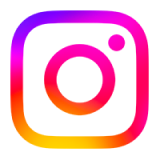
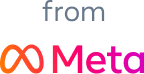
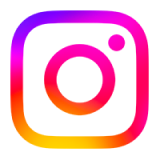
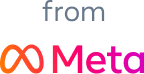
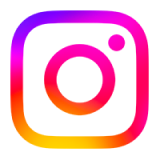
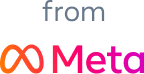
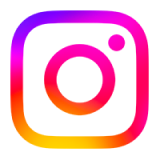
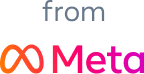
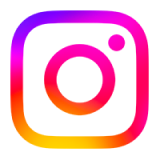
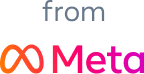

In [36]:
# Analyze each link in the DataFrame
for index, row in df.iterrows():

    print(f"Analyzing {index + 1} of {len(df)}: {row['Link']}") # type: ignore

    link = row['Link']
    page_size = get_page_size(link)
    resource_sizes = analyze_resources(link)
    
    # Update the DataFrame with the results
    df.at[index, 'Page Size (KB)'] = page_size
    df.at[index, 'Resource Sizes'] = resource_sizes

    print(f"Page size: {page_size} KB")
    print(f"Resource sizes: {resource_sizes}")

    # Save the DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)

print(f"Analysis results saved to '{output_csv}'.")

In [41]:
# Load the data
df = pd.read_csv('resources.csv')

# Convert the 'Resource Sizes' column from string to a list of tuples
df['Resource Sizes'] = df['Resource Sizes'].apply(ast.literal_eval)

# Compute the total resource size and number of resources for each page
df['Total Resource Size (KB)'] = df['Resource Sizes'].apply(lambda x: sum(size for url, size in x))
df['Resource Count'] = df['Resource Sizes'].apply(len)

In [53]:
# 1. Histogram of Page Sizes
fig = px.histogram(df, x='Page Size (KB)')
fig.update_layout(title='Page Sizes', xaxis_title='Page Size (KB)', yaxis_title='Count')
fig.show()
fig.write_html('../../fam-report-site/public/Web-Analytics/page_sizes.html')

In [54]:
# 2. Histogram of Total Resource Sizes
fig = px.histogram(df, x='Total Resource Size (KB)')
fig.update_layout(title='Total Resource Sizes', xaxis_title='Total Resource Size (KB)', yaxis_title='Count')
fig.show()
fig.write_html('../../fam-report-site/public/Web-Analytics/total_resource_sizes.html')

In [57]:
# 5. Histogram of Resource Count per Page
fig = px.histogram(df, x='Resource Count')
fig.update_layout(title_text='Resource Count per Page')
fig.show()
fig.write_html('../../fam-report-site/public/Web-Analytics/resource_counts.html')

In [55]:
top_pages = df.nlargest(30, 'Page Size (KB)')
fig = px.bar(top_pages, x='Link', y='Page Size (KB)')
fig.update_layout(title_text='Top 30 URLs by Page Size')
fig.update_layout(showlegend=False)
fig.show()
fig.write_html('../../fam-report-site/public/Web-Analytics/top_pages.html')

In [56]:
top_resources = df.nlargest(30, 'Total Resource Size (KB)')
fig = px.bar(top_resources, x='Link', y='Total Resource Size (KB)', labels={'Link': '', 'Total Resource Size (KB)': 'Resource Size (KB)'})
fig.update_traces(textposition='auto')
fig.update_layout(showlegend=False)
fig.update_layout(title_text='Top 30 URLs by Total Resource Size')
fig.show()
fig.write_html('../../fam-report-site/public/Web-Analytics/top_resources_bar.html')